In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics.pairwise import haversine_distances

# Data Exploration

In [26]:
data = pd.read_csv("sample_data.csv")
data.head()

,mmsi,timestamp,lat,lon
0,565761000,2023-03-15 00:27:44+00,1.26878,103.75827
1,538008084,2023-03-19 23:30:00+00,43.55962,10.29404
2,564654000,2023-03-12 08:22:53+00,1.23725,103.89135
3,529123000,2023-03-05 16:47:42+00,29.44367,48.93066
4,564780000,2023-03-11 06:35:20+00,1.27755,103.61026


In [27]:
data.describe()

,mmsi,lat,lon
count,1.350100e+04,13501.000000,13501.000000
mean,5.424352e+08,7.096132,78.095846
std,8.704486e+07,12.937516,53.279099
min,2.187191e+08,-32.213560,-89.889167
25%,5.630146e+08,1.235940,103.610320
50%,5.646540e+08,1.262690,103.809770
75%,5.646540e+08,1.302477,103.903350
max,8.989988e+08,50.705240,121.841440


In [28]:
data["mmsi"].nunique()

17

In [29]:
data["timestamp"].nunique()

10916

In [30]:
type(data["timestamp"][0])

str

In [31]:
# Converting timestamp strings to pandas timestamp format
print(data["timestamp"][0])
print(pd.to_datetime(data["timestamp"][0]))

data["timestamp"] = pd.to_datetime(data["timestamp"])
type(data["timestamp"][0])

2023-03-15 00:27:44+00
2023-03-15 00:27:44+00:00


pandas._libs.tslibs.timestamps.Timestamp

In [32]:
# If there is only one vessel at a particular timestamp, the timestamp can be ignored
grouped_by_timestamp = data.groupby("timestamp").size()
timestamps_gt_one = grouped_by_timestamp[grouped_by_timestamp > 1].index
data = data[data["timestamp"].isin(timestamps_gt_one)]

In [33]:
data.describe()

,mmsi,lat,lon
count,3.082000e+03,3082.000000,3082.000000
mean,5.187048e+08,12.631180,48.565061
std,1.443525e+08,17.337806,68.541241
min,2.187191e+08,-32.145072,-79.918500
25%,5.189983e+08,1.273738,9.095799
50%,5.630146e+08,1.301594,103.655683
75%,5.647800e+08,29.065170,103.935135
max,8.989988e+08,44.333265,104.095353


In [34]:
data["timestamp"].nunique()

497

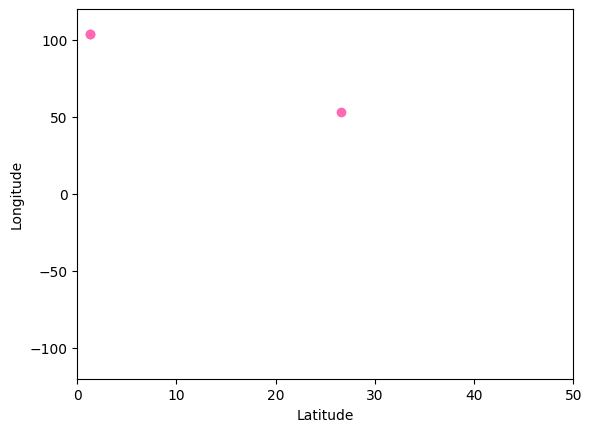

In [35]:
def plot_frame(timestamp):
    filtered_data = data[data["timestamp"] == timestamp]
    plt.cla()
    plt.scatter(filtered_data["lat"], filtered_data["lon"], color="hotpink")

    plt.xlim(0, 50)
    plt.ylim(-120, 120)

    plt.xlabel("Latitude")
    plt.ylabel("Longitude")

fig, ax = plt.subplots()
sorted_timestamps = sorted(data["timestamp"].unique())
animation = FuncAnimation(fig, plot_frame, sorted_timestamps, repeat=False)
animation.save("animation.mp4")

# Proximity Calculation

In [36]:
# Converting to radians
data["lat"] = data["lat"] * np.pi / 180
data["lon"] = data["lon"] * np.pi / 180

In [37]:
def haversine_distance(group):
    dist = np.array(haversine_distances(group[["lat", "lon"]], group[["lat", "lon"]]))
    result = group.merge(group, how='cross', suffixes = ("_1", "_2"))
    result["dist"] = dist.flatten()
    return result

result = data.groupby("timestamp").apply(haversine_distance)

In [38]:
result.head()

mmsi_1               timestamp_1     lat_1  \
timestamp                                                                    
2023-03-04 14:30:00+00:00 0  564780000 2023-03-04 14:30:00+00:00  0.022653   
                          1  564780000 2023-03-04 14:30:00+00:00  0.022653   
                          2  564780000 2023-03-04 14:30:00+00:00  0.022653   
                          3  529123000 2023-03-04 14:30:00+00:00  0.464632   
                          4  529123000 2023-03-04 14:30:00+00:00  0.464632   

                                lon_1     mmsi_2               timestamp_2  \
timestamp                                                                    
2023-03-04 14:30:00+00:00 0  1.814210  564780000 2023-03-04 14:30:00+00:00   
                          1  1.814210  529123000 2023-03-04 14:30:00+00:00   
                          2  1.814210  563014650 2023-03-04 14:30:00+00:00   
                          3  0.928417  564780000 2023-03-04 14:30:00+00:00   
                          4  0.928417  529123000 2023-03-04 14:30:00+00:00   

                                lat_2     lon_2      dist  
timestamp                                                  
2023-03-04 14:30:00+00:00 0  0.022653  1.814210  0.000000  
                          1  0.464632  0.928417  0.957449  
                          2  0.022120  1.813278  0.001073  
                          3  0.022653  1.814210  0.957449  
                          4  0.464632  0.928417  0.000000

In [39]:
# Removing rows with equal MMSI
data = result[result["mmsi_1"] != result["mmsi_2"]]

In [40]:
data["dist"].describe()

count    2.056200e+04
mean     1.250103e+00
std      1.030099e+00
min      1.019054e-07
25%      4.997555e-03
50%      1.044713e+00
75%      1.649126e+00
max      2.958223e+00
Name: dist, dtype: float64

In [46]:
threshold = 1.6

def vessels_within_threshold(group):
    return group[group["dist"] < threshold]["mmsi_2"].tolist()

result = data.groupby("mmsi_1").apply(vessels_within_threshold)
print(result)

mmsi_1
218719092    [875832716, 529123000, 232345740, 232006548, 5...
232006548    [875832716, 529123000, 218719092, 232345740, 5...
232345740    [875832716, 529123000, 218719092, 232006548, 5...
352002300    [564780000, 564780000, 565761000, 563078430, 5...
352656000    [538008084, 538008084, 538008084, 538008084, 5...
518998309    [563014650, 232345740, 218719092, 232006548, 5...
529123000    [564780000, 563014650, 564780000, 564654000, 5...
538008064    [352656000, 352656000, 352656000, 352656000, 3...
538008084    [565761000, 352656000, 563014650, 565761000, 3...
563014650    [564780000, 529123000, 529123000, 564780000, 5...
563078430    [529123000, 564780000, 565761000, 563014650, 5...
564654000    [564780000, 529123000, 563014650, 529123000, 5...
564780000    [529123000, 563014650, 564654000, 529123000, 5...
565761000    [564780000, 529123000, 564780000, 563014650, 5...
875832716    [529123000, 218719092, 232345740, 232006548, 5...
889799564    [232345740, 529123000, 232006548, 3